# DATA CLEANING

In [374]:
import re
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [375]:
import warnings
warnings.filterwarnings('ignore')

# Coffee Review

In [720]:
df = pd.read_csv('../data_raw/coffee_review.csv')      

In [721]:
df.head()

,Unnamed: 0,coffee,cr_rating,coffee_origin,roaster,roaster_location,roast_level,aroma,acidity_structur,body,flavor,agtron,review,review_date,price_estimate
0,0,Kenya,95,"Nyeri growing region, south-central Kenya",CafeTaster,"Taipei City, Taiwan",Medium-Light,9,9,9,9,62/77,"Nuanced, multi-layered. Almond brittle, pomegr...",August 2022,NT $600/227 grams
1,1,Peru,92,"Cusco Province, Peru",CafeTaster,"Taipei City, Taiwan",Medium-Light,8,8,9,9,58/77,"Rich-toned, chocolaty. Baking chocolate, cashe...",August 2022,NT $500/227 grams
2,2,San Jose Mexico,93,"oatepec, Veracruz State, Mexico",JBC Coffee Roasters,"Madison, Wisconsin",Medium-Light,9,8\t\t\t\t\t\t\t,9,8,57/77,"Evaluated as espresso. Richly chocolaty, deepl...",August 2022,$17.00/12 ounces
3,3,Bella Carmona Guatemala,93,"Antigua growing region, Guatemala",JBC Coffee Roasters,"Madison, Wisconsin",Medium-Light,9,8\t\t\t\t\t\t\t,9,8,60/78,"Evaluated as espresso. Caramel, almond butter,...",August 2022,$17.00/12 ounces
4,4,Karen J Kona Red Bourbon,96,"Holualoa, North Kona growing district, “Big Is...",Hula Daddy Kona Coffee,"Holualoa, Hawai’i",Medium-Light,10,9,8,10,58/78,"Deep-toned, complexly layered, vibrantly aroma...",August 2022,$49.95/8 ounces


In [722]:
df.coffee_origin

0               Nyeri growing region, south-central Kenya
1                                    Cusco Province, Peru
2                         oatepec, Veracruz State, Mexico
3                       Antigua growing region, Guatemala
4       Holualoa, North Kona growing district, “Big Is...
                              ...                        
6752                                         Medium-Light
6753                                                 Dark
6754                                               Medium
6755                                                Light
6756                                          Medium-Dark
Name: coffee_origin, Length: 6757, dtype: object

In [723]:
df.agtron

0               62/77
1               58/77
2               57/77
3               60/78
4               58/78
            ...      
6752    February 1997
6753    February 1997
6754    February 1997
6755    February 1997
6756    February 1997
Name: agtron, Length: 6757, dtype: object

In [724]:
# When looking at the df it seems that the information that was scraped was slipping into different columns.         
# Continuing forward I will focus on the most relevant information: Roast Level, Origin, Variety, Process

level = ['Medium-Light', 'Light', 'Medium', 'Medium-Dark', 'Dark', 'Very Dark']

index = []
ml = []
for idx, elem in enumerate(df['coffee_origin']): # Gathering Roast Level from Coffee Origin
    if elem in level:
        index.append(idx)
        ml.append(elem)
        

agtron = df.roast_level.iloc[index] # Gathering the agtron values from the roast_level columns.
df.agtron.iloc[index] = agtron # Set Agtron on the slipped indexes to agtron values collected from roast level column
df.roast_level.iloc[index] = ml #Set Roast Level on the slipped indexes to ml (the roast levels)
df.coffee_origin = [np.NaN if i in level else i for i in df.coffee_origin] # setting the extracted values to NaN 

Medium-Light    2897
Medium          1507
Medium-Dark      766
Light            609
Very Dark        386
Dark             232
/                230
0/0               11
Name: roast_level, dtype: int64

In [387]:
# Picking the most relevant columns from the total dataframe:
x = df[['coffee', 'coffee_origin', 'roaster', 'roast_level', 'review']]

In [389]:
#Dealing with NaNs
x.isna().sum()

coffee             0
coffee_origin    513
roaster            0
roast_level      119
review             4
dtype: int64

In [390]:
x.coffee_origin.value_counts()

Not disclosed.                                                    372
Guji Zone, Oromia Region, southern Ethiopia                       303
Yirgacheffe growing region, southern Ethiopia                     143
Not disclosed                                                     142
Boquete growing region, western Panama                            137
                                                                 ... 
Biolley, southern Costa Rica                                        1
Nakuru County, south-central Kenya                                  1
Ethiopia; Costa Rica; Panama                                        1
Kirumba, North Kivu Province, Democratic Republic of the Congo      1
Indonesia, Central and South America                                1
Name: coffee_origin, Length: 2010, dtype: int64

In [394]:
#Setting all non informativ values to 'not disclosed'
x.coffee_origin.loc[x.coffee_origin == 'Not disclosed.'] = 'not disclosed'
x.coffee_origin.loc[x.coffee_origin == 'Not disclosed'] = 'not disclosed'
x.coffee_origin = x.coffee_origin.fillna('not disclosed')

In [396]:
# Coffee Origin is a combination of Country and Region: 
## Next Step is to split Origin into Country and Region Columns:

x['coffee_country'] = [i.split(',')[-1] for i in x['coffee_origin']]

# Removing the Country Part from Origin and saving it in new column Region
x['coffee_region'] = [x['coffee_origin'][idx].replace(x['coffee_country'][idx], '') for idx, row in x.iterrows()]


In [400]:
# Dealing with NaNs in Roast Level
x.isna().sum()

coffee              0
coffee_origin       0
roaster             0
roast_level       119
review              4
coffee_country      0
coffee_region       0
dtype: int64

In [401]:
x.roast_level.describe()

count             6638
unique               8
top       Medium-Light
freq              2897
Name: roast_level, dtype: object

<AxesSubplot:xlabel='roast_level', ylabel='Count'>

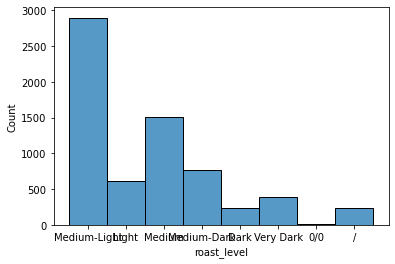

In [402]:
sns.histplot(x.roast_level)

In [403]:
x.roast_level.value_counts()

Medium-Light    2897
Medium          1507
Medium-Dark      766
Light            609
Very Dark        386
Dark             232
/                230
0/0               11
Name: roast_level, dtype: int64

In [404]:
# Clustering the Roast Levels into the most used Levesl by professionals:
x.loc[x.roast_level == 'Very Dark', 'roast_level'] = 'Dark'
x.loc[(x.roast_level == '/') | (x.roast_level == '0/0'), 'roast_level'] = 'Medium-Light'

In [406]:
x.roast_level = x.roast_level.fillna(x.roast_level.mode()[0]) # Filling NaN with Mode 

In [409]:
# Only Review NaNs left
x.isna().sum()

coffee            0
coffee_origin     0
roaster           0
roast_level       0
review            4
coffee_country    0
coffee_region     0
dtype: int64

In [410]:
# Most important Column. Needed to have informative values. Dropping the NaNs
x = x.drop(np.where(x.review.isna())[0], axis = 0)

In [411]:
## Saving Cleaned DF
# x.to_csv('../data_clean/coffee_review.csv', index=False)

# Misto Box

In [413]:
file = pd.read_csv('../data_raw/misto.csv')

In [414]:
file.head()

,Unnamed: 0,coffee_title,roaster,coffee_origin,coffee_region,variety,farmer,roast_level,flavor,coffee_type,altitude
0,0,Kenya Ichamama,Panther Coffee Roasters,Kenya,Nyeri,"SL-28, SL-34, Ruiru 11, Batian",Othaya Farmers Cooperative Society,Light,"['nectarine', 'jasmine', 'bright']",Single Origin,1850
1,1,Papua New Guinea AAK Cooperative,Sightglass Coffee,Papua New Guinea,"Obura-Wonenara, Eastern Highlands","Bourbon, Caturra",AAK Cooperative,Medium,"['pomegranate', 'lemon', 'complex']",Single Origin,1500-1650
2,2,Cold Brew,Barefoot Coffee Roasters,Guatemala,Huehuetenango,NaN,NaN,Medium,"['chocolate', 'citrus', 'rich']",Single Origin,NaN
3,3,Capital Cold Brew Blend,Temple Coffee,"Brazil, Colombia, Ethiopia","Campos Altos, Guji, Huila",NaN,NaN,Medium,"['cherry', 'milk chocolate', 'vibrant']",Blend,1000-2000
4,4,Ethiopia Dur Feres,Methodical Coffee,Ethiopia,Sidama,"74/158, 74/110, Setami, Mikicho",various small producers,Medium-light,"['blueberry', 'blackberry', 'juicy']",Single Origin,1800


In [415]:
# Selecting most interesting columns:
df = file[['coffee_title', 'roaster', 'coffee_origin', 'coffee_region', 'variety', 'roast_level', 'flavor']]

In [416]:
#Dealing with NaNs
df.isna().sum()

coffee_title       0
roaster            0
coffee_origin     52
coffee_region    455
variety          239
roast_level        0
flavor             0
dtype: int64

In [418]:
df.coffee_region = df.coffee_region.fillna('not disclosed') #Can not be filled with Mode (makes no sense)
df.coffee_origin = df.coffee_origin.fillna('not disclosed') #Can not be filled with Mode (makes no sense)
df.variety = df.variety.fillna('not disclosed') #Can not be filled with Mode (makes no sense)

In [424]:
# Cleaning Flavor
for idx, elem in enumerate(df.flavor):
    df.flavor[idx]= re.sub('\W', ' ', elem)
df.flavor = [i.strip() for i in df.flavor]

In [427]:
#df.to_csv('../data_clean/mistobox.csv', index=False)

# 19Grams

In [428]:
file = pd.read_csv('../data_raw/19grams_filter.csv')

In [429]:
file.head()

,Unnamed: 0,coffee_name,sca_rating,price/kg,coffee_variety,review,review2,roaster,purchase,type
0,0,\n 4 Llamas Geisha - Bolivien F...,Score: 90,NaN,Geisha,"\n Mandarine, Grüner Apfel, Jasmin\n","['Süße: ', 'Himbeer ', 'Schokolade', 'Säure: '...",19grams_coffee,https://19grams.coffee/,filter
1,1,\n Rockstar Coffee Club\n ...,NaN,"\nStückpreis\n\n\n70,00 €\n\n/\n pro \nkg\n ...",NaN,NaN,NaN,19grams_coffee,https://19grams.coffee/,filter
2,2,\n Don Martin Geisha Enano - Co...,Score: 91,NaN,Geisha,"\n Erdbeere, Clementine, Heckenkirsche\n","['Süße: ', 'Wilderdbeere', 'Säure: ', 'Balsami...",19grams_coffee,https://19grams.coffee/,filter
3,3,\n Fazenda Santuàrio Sul Yirgac...,Score: 88,NaN,Yirgacheffe,"\n Blaubeere, Haselnuss, Bergamotte\n","['Süße: gebrannte ', 'Mandeln', 'Säure: ', 'We...",19grams_coffee,https://19grams.coffee/,filter
4,4,\n El Diviso Sidra - Kolumbien ...,Score: 89,NaN,Sidra,"\n Aprikose, kandierter Ingwer, Nougat\n","['Süße: ', 'Säure: ', 'Milchsäure', 'Mundgefüh...",19grams_coffee,https://19grams.coffee/,filter


In [430]:
# Picking most relevant columns
df = file[['coffee_name', 'coffee_variety', 'review', 'review2', 'roaster']]

In [431]:
# Dealing with NaNs
df.isna().sum()

coffee_name       0
coffee_variety    8
review            1
review2           3
roaster           0
dtype: int64

In [432]:
df.coffee_variety = df.coffee_variety.fillna('not_disclosed')
df.drop(np.where(df.review.isnull())[0], axis = 0) # Dropping the review NaN raws

In [437]:
# Coffee Name is again a compound of Name and Country
# Splitting Coffee Name and setting new column Coffee Title

df.coffee_name = [i.split('\n')[1].strip() for i in df.coffee_name]
df['coffee_title'] = [i.split('-')[0].strip() for i in df.coffee_name]

# Splitting and extracting Coffee Country
coffee_country = []
for i in df.coffee_name:
    try: 
        coffee_country.append(i.split('-')[1].strip())
    except: 
        coffee_country.append('not disclosed')

df['coffee_country'] = coffee_country

In [438]:
df.coffee_country

0                       Bolivien Filter
1                         not disclosed
2                     Costa Rica Filter
3                      Brasilien Filter
4                      Kolumbien Filter
5                        Low Caf Filter
6                         Ruanda Filter
7                      Kolumbien Filter
8                      Kolumbien Filter
9                      Kolumbien Filter
10    entkoffeinierter Kolumbien Filter
11                         Filter Blend
Name: coffee_country, dtype: object

In [439]:
# Further cleaning
country = ['Bolivien', 'Costa Rica', 'Brasilien', 'Kolumbien', 'Ruanda']
df.coffee_country = [i.replace('Filter', '') for i in df.coffee_country] # Removing 'Filter'

In [440]:
for idx, elem in enumerate(df.coffee_country):    
    if elem.strip().replace('entkoffeinierter', '') in country: # Setting to country list
        df.coffee_country[idx] = elem
    else: 
        df.coffee_country[idx] = 'not disclosed' # or 'not disclosed'

In [444]:
# Cleaning column review2

df.review2 = df.review2.fillna('not disclosed')
df.review2 = [re.sub('\W', ' ', i) for i in df.review2]
df.review2 = [i.replace('Süße', '') for i in df.review2]
df.review2 = [i.replace('Säure', '') for i in df.review2]
df.review2 = [i.replace('Mundgefühl', '') for i in df.review2]
df.review2 = [i.replace('Körper', '') for i in df.review2]

df.review2

In [445]:
# combining review and review2 columns
for idx, row in df.iterrows():
    df.review[idx] = str(df.review[idx]) + str(df.review2[idx])
    
df.review = df['review'].str.replace('\n', ' ')

In [447]:
df.review

0            Mandarine, Grüner Apfel, Jasmin        ...
1                                      nannot disclosed
2            Erdbeere, Clementine, Heckenkirsche    ...
3            Blaubeere, Haselnuss, Bergamotte       ...
4            Aprikose, kandierter Ingwer, Nougat    ...
5            Malz, Orange, weiße Schokolade         ...
6            Erdbeere, Mango, Ahornsirup            ...
7            Weiße Schokolade, Mandel, Birne        ...
8            Honigmelone, Milchschokolade, Orangenbl...
9            Karamell, Maracuja, Orange             ...
10           Reife Feige, Brauner Zucker, Dunkle Sch...
11           Weiße Schokolade, Melone, Orangenblüten...
Name: review, dtype: object

In [448]:
df = df.drop(1, axis = 0) # Drop row one because of missing information

In [452]:
# Further cleaning
df.coffee_country.iloc[9] = 'Kolumbien'
df.coffee_country.iloc[10] = 'not disclosed'
df.drop('review2', axis = 1, inplace=True)
df.drop('coffee_name', axis = 1, inplace = True)

# Renaming columns
df.rename(columns =  {'coffee_variety': 'variety',
                     'review': 'flavor_profil'})

In [454]:
#df.to_csv('../data_clean/19grams.csv', index=False)

# CoffeeDiff

In [726]:
file = pd.read_csv('../data_raw/coffeeDiff.csv')
file.drop('Unnamed: 0', axis = 1, inplace=True)

In [727]:
file.head()

,Unnamed: 0,coffee_title,coffee_origin,roaster_name,variety,production,roast_level,flavour
0,0,Peruvian Café Femenino,Peru,Quirky Coffee Co,CaturraBourbonCatuai,Washed,Medium,ChocolateDark ChocolateSweetFloralBerryCherry
1,1,La-Azucena-Espresso,Colombia,Pact,Castillo,Washed,MediumEspresso,CaramelizedVanilla
2,2,Filter - Coffee Bundle 4 X 230g,China,Carnival,BourbonRobiaceae CoffeaCatimor / AtengJackson,Washed,LightFilter,CaramelizedHoneyRoseJasmineFloralBlueberryPome...
3,3,Colombia | Finca El Mirador,Rwanda,Roost,Bourbon,Washed,Medium Dark,CocoaMolassesFloral
4,4,Indian Monsooned Malabar Aa Green Coffee Beans,Ethiopia,Rave,Typica,"Natural, Monsooned",Green,Roasted


In [458]:
file.isna().sum()

coffee_title      123
coffee_origin      96
roaster_name       97
variety           630
production        698
roast_level      1123
flavour           248
dtype: int64

In [460]:
file.dropna(subset = ['coffee_title'], inplace=True) # droping because vital for the model
file.dropna(subset = ['flavour'], inplace=True)

In [462]:
# Huge amount fo different Roast Levels
file.roast_level.value_counts()

Omni                    455
Espresso                325
Medium                  284
Filter                  185
MediumOmni              136
Dark                    103
Green                    99
Medium Dark              89
Light                    81
MediumEspresso           69
Medium Light             66
MediumFilter             43
Extra Dark               35
DarkEspresso             29
Medium DarkEspresso      27
LightFilter              27
DarkOmni                 26
Medium LightOmni         25
Medium DarkOmni          24
LightOmni                23
Medium LightFilter       14
DarkFilter               14
Extra DarkOmni           12
LightEspresso             8
Medium LightEspresso      8
Medium DarkFilter         6
Extra DarkEspresso        6
GreenFilter               3
Extra DarkFilter          3
GreenEspresso             2
Silly DarkEspresso        1
Silly DarkOmni            1
Extra LightEspresso       1
GreenOmni                 1
Name: roast_level, dtype: int64

In [467]:
# ASSUMTPION that Filter is roasted ligth, Omni medium and Espresso dark
file.loc[file.roast_level == 'Filter', 'roast_level'] = 'Light'
file.loc[file.roast_level == 'Espresso', 'roast_level'] = 'Dark'
file.loc[file.roast_level == 'Omni', 'roast_level'] = 'Medium'

# If dark, light or medium in Name i will label it as such: 
file.roast_level = [i.replace('Espresso', '') if not pd.isna(i) else np.NaN for i in file.roast_level ]
file.roast_level = [i.replace('Filter', '') if not pd.isna(i) else np.NaN for i in file.roast_level ]
file.roast_level = [i.replace('Omni', '') if not pd.isna(i) else np.NaN for i in file.roast_level ]
file.roast_level = [i.replace('Extra', '') if not pd.isna(i) else np.NaN for i in file.roast_level ]
file.roast_level = [i.replace('Silly', '') if not pd.isna(i) else np.NaN for i in file.roast_level ]


In [468]:
file.roast_level.unique()

array(['Medium', 'Light', 'Medium Dark', 'Green', 'Dark', ' Dark',
       'Medium Light', nan, ' Light'], dtype=object)

In [469]:
# Dealing with Flavor NaNs:
file.isna().sum()

coffee_title       0
coffee_origin      0
roaster_name       0
variety          379
production       446
roast_level      896
flavour            0
dtype: int64

In [470]:
file.flavour

0           ChocolateDark ChocolateSweetFloralBerryCherry
1                                      CaramelizedVanilla
2       CaramelizedHoneyRoseJasmineFloralBlueberryPome...
3                                     CocoaMolassesFloral
4                                                 Roasted
                              ...                        
3265                                       ChocolateWiney
3266                                                Sweet
3267                                                Nutty
3268                                                Sweet
3300                                          SweetFruity
Name: flavour, Length: 3127, dtype: object

In [474]:
# Splitting Words: 
file.flavour = [re.findall('[A-Z][^A-Z]*', i) for i in file.flavour]

# Change from list to string:
for idx, flav in enumerate(file.flavour):
    file.flavour[idx]= ' '.join(str(elem) for elem in flav).strip()
    

# Cleaning string:
for idx, flav in enumerate(file.flavour):
    file.flavour[idx]= re.sub('\W', ' ', str(flav).strip())

file.flavour

In [475]:
#file.to_csv('../data_clean/coffeeDiff_all_flavours.csv', index=False)

# Reddit

In [728]:
file = pd.read_csv('../data_raw/Coffees-All Brews.csv')

In [729]:
display(file.head())

# select most relevant columns
df = file[['Name', 'Company', 'Origin', 'Flavors', 'Process']]

#rename columns
df.columns = ['coffee_title', 'roaster', 'coffee_country', 'flavours', 'Production']

,Name,Currently Brewing,Personal Rating,Company,Origin,Flavors,Single Origin,Notes,Price (250g),Image,Date,Process,Subscriptions,Count
0,Sitio Tres Baras,checked,NaN,Brew Coffee Plus,Brazil,"Cherry,Chocolate,Complex",checked,NaN,£10.00,2022-09-11 07.37.09.jpg (https://dl.airtable.c...,11.9.2022,Pulped Natural,NaN,1.0
1,Bookisa,checked,NaN,Coaltown,Ethiopia,"Orange,Jasmine honeysuckle,Molasses",checked,NaN,£10.00,2022-09-10 12.27.39.jpg (https://dl.airtable.c...,10.9.2022,Natural,Coaltown,1.0
2,Rafael Amaya,NaN,3.0,The Roasting Shed,Colombia,"Cacao nibs,Lychee,Rose petals",checked,"200 hour fermentation, wild flavours!",£15.00,2022-09-04 12.56.24.jpg (https://dl.airtable.c...,1.9.2022,Natural,NaN,1.0
3,Finca Bethania,NaN,4.0,Yallah,Nicaragua,"Tropical,Jammy,Guava,Syrupy-sweet",checked,NaN,£10.00,2022-08-18 09.28.37.jpg (https://dl.airtable.c...,18.8.2022,Natural,Yallah Explore,1.0
4,Jose Angel Parra,NaN,NaN,Coaltown,Colombia,"Maple syrup,Demerara sugar,Plum",checked,NaN,£10.00,2022-08-13 07.06.47.jpg (https://dl.airtable.c...,11.8.2022,Washed,Coaltown,1.0


In [480]:
df.dropna(inplace=True) # Dropping all NaNs

In [484]:
#df.to_csv('../data_clean/reddit.csv', index=False)

# Fellow

In [487]:
file = pd.read_csv('../data_raw/fellow_abo.csv')

file.drop('Unnamed: 0', axis = 1, inplace=True
file.isna().sum()
          
#No cleaning needed :D

In [488]:
#file.to_csv('../data_clean/fellow.csv', index = False)

# Gardelli

In [735]:
file = pd.read_csv('../data_raw/gardelli.csv')

In [736]:
df= file[['title', 'land', 'region', 'variety', 'aufbereitung', 'review_text']]

In [737]:
df.head()

,title,land,region,variety,aufbereitung,review_text
0,Ninety Plus Competition Set (Panama),"Silla de Pando, Volcan",1500-1700 masl,March 2020,Geisha,Yuzu Lemon / Loquat / Sidr Honey / YogurtUBO 5...
1,"La Siria, Geisha (Colombia)",Colombia,Huila,Geisha,Classic Washed,Lemongrass / Lavender/ Rosemary/ Lime/Mandarine
2,"Inmaculada, Sudan Rume (Colombia)",Colombia,Cauca,Sudan Rume,Anaerobic Natural,Vanilla / Mango / Orange / Lychee / Red Grape
3,Francis Kipsang (Uganda),Uganda,Sipi Falls,SL28,Gardelli Orange,Elder Flower/ Mango/ Peach/Pear / Kiwi
4,Hassan Al Amer (Yemen),Yemen,Haraz,Yemen heirlooms,Anaerobic Natural,Rose/ Chamomile/ Hibiscus/ Blood Orange/ Cloves


In [738]:
# Manually Cleaning

df.land[14] = 'Ethiopia'
df.region[14] = 'Yirgacheffe'
df.variety[14] = df.aufbereitung[14]
df.aufbereitung[16] = df.region[16]
df.land[16] = 'Guatemala'
df.region[16] = 'Finca Bella Vista'
df.aufbereitung[16] = np.NaN
df.region[0] = df.land[0]
df.variety[0] = 'Geisha'
df.aufbereitung[0] = np.NaN
df.land = 'Panama'
df.aufbereitung[14] = np.NaN

In [741]:
df.aufbereitung= df.aufbereitung.fillna(df.aufbereitung.mode()[0]) #Fill NaN with Mode

In [743]:
#df.to_csv('../data_clean/gardelli.csv', index=False)

# Happy Coffee

In [506]:
file = pd.read_csv('../data_raw/happycoffee.csv')

In [508]:
file.isna().sum()

df = file[['coffee_title', 'roaster', 'coffee_origin', 'variety', 'production', 'flavor']]

# Happy Coffee is not useful for now!

# Kaffeezentrale

In [744]:
file = pd.read_csv('../data_raw/kaffeezentrale.csv')

In [745]:
df = file[['coffee_title', 'review_text']] # Select most important columns

In [746]:
df.isna().sum()

coffee_title    3
review_text     6
dtype: int64

In [747]:
df.dropna(inplace=True)
#ONLY FLAVOURS

In [748]:
df.head()

,coffee_title,review_text
0,Cerutti Â«il CaffÃ¨Â» Milano,"Vollmundig, gehaltvoll, schokoladig und leicht..."
1,New York Extra (Bluemountain),"schokoladig, voll, rund, lang anhaltend"
2,BlasercafÃ© Lilla e Rose,"Ausgesprochen angenehm rund, aber sehr wuchtig"
3,Black and Blaze Premium,"Schokoladig, zartbitter, sehr sÃ¼ss und vollmu..."
4,CaffÃ¨ Ferrari Espresso Milano,"kraftvoll, aromatisch, sÃ¤urearm, lang anhaltend"


In [514]:
#df.to_csv('../data_clean/kaffeezentrale.csv')

# Kaffeeothek

In [749]:
file = pd.read_csv('../data_raw/kaffeothek.csv')
file.drop('Unnamed: 0', axis=1, inplace=True)

In [752]:
# Combining descriptor columns and dropping original columns:
file['review_text'] = file.description + file.aroma_desrciptor
file.drop('aroma_desrciptor', axis=1, inplace=True)
file.drop('description', axis=1, inplace=True)

In [753]:
file.head()

,coffee_title,roaster,coffee_origin_country,coffee_variety,roast_level,review_text
0,Nero,Röstraum,"Indonesien, Brasilien, Indien","70% Arabica, Typica, Yellow Bourbon, 30% Robusta",Dunkel,"Wer es gern sehr kräftig, kurz und italienisch..."
1,Aurelia,Kanzi Kaffee,"Brasilien, Kolumbien, Indien","60% Arabica, 40% Robusta",Dunkel,Ein absoluter Klassiker! Wenn man beim Italien...
2,Frühstücksmischung,Alt Wien,\nwashed,Arabica,Mittel,Perfekt für einen entspannten und unkomplizier...
3,Milano,Suchan,"Kenia, Äthiopien, Indien, Nicaragua, Brasilien","95% Arabica, 5% Robusta",Dunkel,Die Stadt in der norditalienischen Lombardei g...
4,"Estate Coffee, Grower`s Roast",Zalvera,El Salvador,"Arabica, Bourbon, Cuscatleco",Mittel,"An den Hängen des Vulkans Santa Ana, auf einer..."


In [518]:
file.drop(2, axis = 0, inplace=True) # To harmonize different dfs

In [521]:
file.isna().sum()

coffee_title             0
roaster                  0
coffee_origin_country    0
coffee_variety           0
roast_level              3
review_text              0
dtype: int64

In [522]:
file.roast_level=file.roast_level.fillna(file.roast_level.mode()[0]) # Dealing with NaNs - Mode

In [524]:
#file.to_csv('../data_clean/kaffeothek.csv', index=True)

# Coffee Friends

In [712]:
file = pd.read_csv('../data_raw/coffeefriends.csv')

file.dropna(inplace=True) # dop all NaNs

# Pick most important columns:
df = file[['coffee_title', 'coffee_origin', 'coffee_region', 'variety', 'production', 'roast', 'review_text']]

df = df.reset_index(drop=True) 


# Removing unnecessary information from columns:
for idx, row in df.iterrows():
    df.variety[idx] = df.variety[idx].replace('VARIETÄT: ', '')
    df.coffee_region[idx] = df.coffee_region[idx].replace('REGION: ', '')
    df.production[idx] = df.production[idx].replace('AUFBEREITUNG: ', '')
    df.roast[idx] = df.roast[idx].replace('RÖSTUNG:', '')
    df.roast[idx] = df.roast[idx].replace('RÖSTUNGSPROFIL:' , '')
    df.review_text[idx] = df.review_text[idx].replace('GESCHMACKSPALETTE:', '')
    df.review_text[idx] = df.review_text[idx].replace('GESCHMACKSNOTEN:', '')


# renaming columns
df.rename(columns={'review_text': 'flavour'}) 


# Extracting Country from Coffee Title: 
ml = []
for idx, val in enumerate(df['coffee_title']):
    ml.append(df.coffee_title[idx].split('„')[1].split(',')[0].split(' ')[:-1])

df['coffee_country'] = ml


# Removing and Replacing Values from country coffee:

for idx, i in enumerate(df.coffee_country):
    for idx, elem in enumerate(i): 
        if elem in ['Blue', 'Santa', 'San', 'Jose', 'La']:
            i[idx] = ''
        elif elem == 'Kopi':
            i[idx] = 'Honduras'       
            

# list to string: 
for idx, i in enumerate(df.coffee_country):
    df.coffee_country[idx] = ' '.join(str(elem) for elem in i)

#Dropping columns
df.drop('coffee_origin', axis=1, inplace=True)

# splitting and picking title
for idx, val in enumerate(df.coffee_title):
    df.coffee_title[idx] = val.split(',')[0]


# setting roast levels to medium, light, dark
for idx, val in enumerate(df.roast):
    val = val.strip()
    if val in ['Mittlere', 'Mittel', 'Mittelstarke']:
        df.roast[idx] = 'medium'
    elif val == 'Leicht':
        df.roast[idx] = 'light'
    else: 
        df.roast[idx] = 'dark'


# setting production process to natural and washed
for idx, val in enumerate(df.production):
    val = val.strip()
    if val == 'Trockene' or val == 'Natürlich':
        df.production[idx] = 'natural'
    elif val == 'Nasse' or val == 'Gewaschen':
        df.production[idx] = 'washed'
    else: 
        df.production[idx] = val.lower()

In [713]:
#df.to_csv('../data_clean/coffee_friend.csv')